In [63]:
# import libraries
import pandas as pd
import scipy.stats
import statsmodels.stats.multitest
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# disable warnings, use w caution
import warnings
warnings.filterwarnings('ignore')

# project specific libs
import os
import matplotlib.pyplot as plt
import pathlib

In [3]:
# project specific path
path = '/Users/KevinBu/Desktop/clemente_lab/Projects/oa/'

In [64]:
# from AC Q2 run of merged saliva stool
df_map = pd.read_csv(path + 'inputs/Qiime2_0/qiime_mapping_file.tsv', sep='\t', index_col=0)
q2_row = df_map.loc['#q2:types',:]
df_map = df_map.drop('#q2:types')

# change index so it matches metadata file
df_map.index = df_map.index.map(lambda x: x.split('.guma')[0])

# drop MOC and elution buffer
df_map = df_map.drop(['MOC.320','elutionbuffer.plate313'])

# split into sample type
df_map_saliva = df_map[df_map['SpecimenType'] == 'Saliva']
df_map_stool = df_map[df_map['SpecimenType'] == 'fecal']

# grab metadata
df_meta = pd.read_csv(path + 'inputs/Metadata_OA.csv')

# rename 'Run_ID_Saliva' to be correct
df_meta['Timepoints'] = df_meta['Timepoints'].apply(lambda x: 'pre' if x == '0' else 'post')
df_meta['Patient_ID'] = df_meta['Patient_ID'].apply(lambda x: x[:-3])  
df_meta['Study_ID'] = df_meta['Study_ID'].apply(lambda x: x.split('_')[0][-3:]) 
df_meta_saliva = df_meta.copy()
df_meta_stool = df_meta.copy()

# grab metadata
df_meta = pd.read_csv(path + 'inputs/Metadata_OA.csv')

# rename 'Run_ID_Saliva' to be correct
df_meta['Timepoints'] = df_meta['Timepoints'].apply(lambda x: 'pre' if x == '0' else 'post')
df_meta['Patient_ID'] = df_meta['Patient_ID'].apply(lambda x: x[:-3])  
df_meta['Study_ID'] = df_meta['Study_ID'].apply(lambda x: x.split('_')[0][-3:]) 
df_meta_saliva = df_meta.copy()
df_meta_stool = df_meta.copy()

df_meta_saliva['#SampleID'] = df_meta['Patient_ID'] + '-' + df_meta['Study_ID'] + '.' + df_meta['Timepoints'] + '.saliva'
df_meta_saliva = df_meta_saliva.set_index('#SampleID')

df_meta_stool['#SampleID'] = df_meta['Patient_ID'] + '-' + df_meta['Study_ID'] + '.' + df_meta['Timepoints'] + '.stool'
df_meta_stool = df_meta_stool.set_index('#SampleID')
df_meta_stool.index = df_meta_stool.index.str.replace('saliva','stool')

# need to repeat for saliva
# create full mapping file
df_map_stool = pd.concat([df_map_stool, df_meta_stool],axis=1)
df_map_saliva = pd.concat([df_map_saliva, df_meta_saliva],axis=1)

# use only sequenced samples
df_map_stool = df_map_stool.dropna(how='any',subset='BarcodeSequence')
df_map_saliva = df_map_saliva.dropna(how='any',subset='BarcodeSequence')

# drop all na
df_map_stool = df_map_stool.dropna(how='all',axis=1)
df_map_saliva = df_map_saliva.dropna(how='all',axis=1)

# export for q2
df_q2_stool = pd.concat([q2_row.to_frame().T, df_map_stool])
df_q2_stool.index.name = '#SampleID'
df_q2_stool.iloc[0,:] = 'categorical'
df_q2_stool.to_csv(path + 'inputs/qiime_mapping_file_stool.tsv', sep='\t')#, index_label='#SampleID')
df_q2_stool = df_q2_stool[df_q2_stool['Adherece_antiinflam'].isin(['Moderate adherence', 'High adherence','categorical'])]
df_q2_stool.to_csv(path + 'inputs/qiime_mapping_file_stool_adh.tsv', sep='\t')#, index_label='#SampleID')

df_q2_saliva = pd.concat([q2_row.to_frame().T, df_map_saliva])
df_q2_saliva.index.name = '#SampleID'
df_q2_saliva.iloc[0,:] = 'categorical'
df_q2_saliva.to_csv(path + 'inputs/qiime_mapping_file_saliva.tsv', sep='\t')#, index_label='#SampleID')
df_q2_saliva = df_q2_saliva[df_q2_saliva['Adherece_antiinflam'].isin(['Moderate adherence', 'High adherence','categorical'])]
df_q2_saliva.to_csv(path + 'inputs/qiime_mapping_file_saliva_adh.tsv', sep='\t')#, index_label='#SampleID')

# redrop q2 row
df_map_stool = df_q2_stool.drop('#q2:types')
df_map_saliva = df_q2_saliva.drop('#q2:types')

# df_map_stool['Adherece_antiinflam']
df_map_saliva.head() #.columns.values


,BarcodeSequence,LinkerPrimerSequence,Separate,SomeOtherInfo,Timepoint,Together,AliquotID,AliquotWeight,AliquotWeightUnit,SpecimenBodySite,...,broccoli,Garbanzo_beans,pork,beef,burger,Total_omega3,Adherence_omega3,Total_omega6,Adherence_omega6,Total_o3_o6
#SampleID,,,,,,,,,,,,,,,,,,,,,
OAD-001.pre.saliva,AGGACAAACTAT,CCGGACTACHVGGGTWTCTAAT,Text,NaN,pre,OAD-001.pre.saliva,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,Low adherence,NaN,Low adherence,0.0
OAD-001.post.saliva,GCAAAGGCCCGC,CCGGACTACHVGGGTWTCTAAT,Limit 45 Characters,NaN,post,OAD-001.post.saliva,NaN,NaN,NaN,NaN,...,4.0,0.0,0.0,0.0,0.0,48.0,Low adherence,72.0,Low adherence,131.0
OAD-003.pre.saliva,TCTTCCTAAAGT,CCGGACTACHVGGGTWTCTAAT,All,NaN,pre,OAD-003.pre.saliva,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,14.0,0.0,16.8,Low adherence,53.2,High adherence,75.0
OAD-003.post.saliva,CTCCCACTAGAG,CCGGACTACHVGGGTWTCTAAT,All,NaN,post,OAD-003.post.saliva,NaN,NaN,NaN,NaN,...,4.0,0.0,0.0,0.0,0.0,48.0,Low adherence,108.0,High adherence,171.0
OAD-004.pre.saliva,CTTGTGCGACAA,CCGGACTACHVGGGTWTCTAAT,All,NaN,pre,OAD-004.pre.saliva,NaN,NaN,NaN,NaN,...,2.8,0.0,0.0,0.0,0.0,2.8,Low adherence,28.0,Low adherence,35.8


In [83]:
# what are we testing?
'''
Hypothesis 1: There will be a measurable difference in WOMAC pain response scores and 
other outcomes from baseline to after the dietary intervention.

Hypothesis 2: There will be an association between oral and gut microbiome and pain outcomes

Hypothesis 3:  The diversity and composition of the saliva and gut microbiome and saliva, 
plasma and gut metabolome profiles will significantly change from baseline to after the 
implementation of ITIS diet among all patients.

Hypothesis 4: The baseline profiles of microbiome and metabolome can be predictive of the 
WOMAC pain response to the diet intervention.
'''

'\nHypothesis 1: There will be a measurable difference in WOMAC pain response scores and \nother outcomes from baseline to after the dietary intervention.\n\nHypothesis 2: There will be an association between oral and gut microbiome and pain outcomes\n\nHypothesis 3:  The diversity and composition of the saliva and gut microbiome and saliva, \nplasma and gut metabolome profiles will significantly change from baseline to after the \nimplementation of ITIS diet among all patients.\n\nHypothesis 4: The baseline profiles of microbiome and metabolome can be predictive of the \nWOMAC pain response to the diet intervention.\n'

In [93]:
# hypothesis 1
# outcome variables
outcomes = ['VAS_Pt', 'VAS_overall', 'WOMAC_pain', 'WOMAC_stiffness', 'WOMAC_activity', 'WOMAC_total', 'Pain_DETECT', 
            'CES_D', 'Helplesness', 'Magnification', 'Rumination', 'PCS_EN', 'Sleep_distrubance', 'PASE_walk', 'PASE_light', 
            #'PASE_gardening', # Where did this go? gardening_improve is binary
            'BMI']


# hypothesis 1
# create a new df_meta
df_meta = pd.read_csv(path + 'inputs/Metadata_OA.csv')

# rename 'Run_ID_Saliva' to be correct
df_meta['Timepoints'] = df_meta['Timepoints'].apply(lambda x: 'pre' if x == '0' else 'post')
df_meta['Patient_ID'] = df_meta['Patient_ID'].apply(lambda x: x[:-3])  
df_meta['Study_ID'] = df_meta['Study_ID'].apply(lambda x: x.split('_')[0][-3:]) 
df_meta['#SampleID'] = df_meta['Patient_ID'] + '-' + df_meta['Study_ID'] + '.' + df_meta['Timepoints'] + '.stool'
df_meta = df_meta.set_index('#SampleID')

# convert % to floats for calculations down the road
bin = []
cont = []
for w in outcomes:
    df_w = df_meta[w]
    if df_w.nunique() > 2: # do spearman
        df_meta[w] = df_meta[w].astype(str).str.replace('%','').astype(float).values
        cont.append(w)
    else:
        bin.append(w)

print(bin)
print(cont)

# split into all and mod high only
for a in ['all','modhigh']:
    print(a)
    if a == 'all':
        job = 'jobs01'
    if a == 'modhigh':
        job = 'jobs02'
        df_meta = df_meta[df_meta['Adherece_antiinflam'].isin(['Moderate adherence', 'High adherence'])]
    print(len(df_meta))
    
    df_results = pd.DataFrame(columns=['var','effect','pval','stat'])
    # do post treatment vals of binary vars differ from pre treatment 'unpaired'
    for b in bin:
        ct_table_ind=pd.crosstab(df_meta["Timepoints"],df_meta[b])
        chi2_stat, p, dof, expected = scipy.stats.chi2_contingency(ct_table_ind)
        row=pd.DataFrame.from_dict({'var': [b],'effect':[chi2_stat],'pval':[p],'stat':['chi2']})
        df_results = pd.concat([df_results, row])
    
    # fishers exact
    for b in bin:
        ct_table_ind=pd.crosstab(df_meta["Timepoints"],df_meta[b])
        fisher, p = scipy.stats.fisher_exact(ct_table_ind)
        row=pd.DataFrame.from_dict({'var': [b],'effect':[t],'pval':[p],'stat':['fisher']})
        df_results = pd.concat([df_results, row])
        
    # do post treatment vals of continuous vars differ from pre treatment unpaired
    df_pre = df_meta[df_meta['Timepoints'] == 'pre']
    df_post = df_meta[df_meta['Timepoints'] == 'post']
    for c in cont:
        try:
            W,p = scipy.stats.mannwhitneyu(x=df_pre[c].values,y=df_post[c].values, nan_policy='omit')
        except:
            W,p = 0, 1
        row=pd.DataFrame.from_dict({'var': [c],'effect':[W],'pval':[p],'stat':['mwu']})
        if p < 0.05:
            ax = sns.boxplot(data=df_meta, x='Timepoints', y=c, orient='v')
            sns.swarmplot(data=df_meta, x='Timepoints', y=c, palette='dark:grey', hue=None, orient='v')
        
            # ax.axes.set_title("Title",fontsize=48)
            ax.set_ylabel(c,fontsize=16)
            ax.set_xlabel('Timepoints',fontsize=16)                
            ax.tick_params(labelsize=16)
            sns.despine()
            plt.tight_layout()
            plt.savefig(path + 'outputs/' + job + '/mwu_' + c  + '.pdf')
            plt.close()            
        row=pd.DataFrame.from_dict({'var': [c],'effect':[W],'pval':[p],'stat':['MWU']})
        df_results = pd.concat([df_results, row])
        
    df_pre = df_meta[df_meta['Timepoints'] == 'pre']
    df_post = df_meta[df_meta['Timepoints'] == 'post']
    for c in cont:
        t,p = scipy.stats.ttest_ind(a=df_pre[c].values,b=df_post[c].values, nan_policy='omit')
        row=pd.DataFrame.from_dict({'var': [c],'effect':[t],'pval':[p],'stat':['ttest']})
        if p < 0.05:
            ax = sns.boxplot(data=df_meta, x='Timepoints', y=c, orient='v')
            sns.swarmplot(data=df_meta, x='Timepoints', y=c, palette='dark:grey', hue=None, orient='v')
        
            # ax.axes.set_title("Title",fontsize=48)
            ax.set_ylabel(c,fontsize=16)
            ax.set_xlabel('Timepoints',fontsize=16)                
            ax.tick_params(labelsize=16)
            sns.despine()
            plt.tight_layout()
            plt.savefig(path + 'outputs/' + job + '/tt_' + c  + '.pdf')
            plt.close()            
        row=pd.DataFrame.from_dict({'var': [c],'effect':[t],'pval':[p],'stat':['ttest']})
        df_results = pd.concat([df_results, row])

    # unpaired and then paired
    df_pre = df_meta[df_meta['Timepoints'] == 'pre']
    df_post = df_meta[df_meta['Timepoints'] == 'post']
    for c in cont:
        W,p = scipy.stats.wilcoxon(x=df_pre[c].values,y=df_post[c].values, nan_policy='omit')
        row=pd.DataFrame.from_dict({'var': [c],'effect':[W],'pval':[p],'stat':['WSR']})
        if p < 0.05:
            ax = sns.boxplot(data=df_meta, x='Timepoints', y=c, orient='v')
            sns.swarmplot(data=df_meta, x='Timepoints', y=c, palette='dark:grey', hue=None, orient='v')
        
            # ax.axes.set_title("Title",fontsize=48)
            ax.set_ylabel(c,fontsize=16)
            ax.set_xlabel('Timepoints',fontsize=16)                
            ax.tick_params(labelsize=16)
            sns.despine()
            plt.tight_layout()
            plt.savefig(path + 'outputs/' + job + '/wsr_' + c  + '.pdf')
            plt.close()            
        row=pd.DataFrame.from_dict({'var': [c],'effect':[W],'pval':[p],'stat':['WSR']})
        df_results = pd.concat([df_results, row])

    df_pre = df_meta[df_meta['Timepoints'] == 'pre']
    df_post = df_meta[df_meta['Timepoints'] == 'post']
    for c in cont:
        t,p = scipy.stats.ttest_rel(a=df_pre[c].values,b=df_post[c].values, nan_policy='omit')
        row=pd.DataFrame.from_dict({'var': [c],'effect':[W],'pval':[p],'stat':['pairedt']})
        if p < 0.05:
            ax = sns.boxplot(data=df_meta, x='Timepoints', y=c, orient='v')
            sns.swarmplot(data=df_meta, x='Timepoints', y=c, palette='dark:grey', hue=None, orient='v')
        
            # ax.axes.set_title("Title",fontsize=48)
            ax.set_ylabel(c,fontsize=16)
            ax.set_xlabel('Timepoints',fontsize=16)                
            ax.tick_params(labelsize=16)
            sns.despine()
            plt.tight_layout()
            plt.savefig(path + 'outputs/' + job + '/pairedt_' + c  + '.pdf')
            plt.close()          
        row=pd.DataFrame.from_dict({'var': [c],'effect':[t],'pval':[p],'stat':['pairedt']})
        df_results = pd.concat([df_results, row])

    df_results.to_csv(path + 'outputs/' + job + '/outcome_testing.tsv', sep='\t')
df_results.head()
    

[]
['VAS_Pt', 'VAS_overall', 'WOMAC_pain', 'WOMAC_stiffness', 'WOMAC_activity', 'WOMAC_total', 'Pain_DETECT', 'CES_D', 'Helplesness', 'Magnification', 'Rumination', 'PCS_EN', 'Sleep_distrubance', 'PASE_walk', 'PASE_light', 'BMI']
all
42
modhigh
32


,var,effect,pval,stat
0,VAS_Pt,198.5,0.008316,MWU
0,VAS_overall,168.5,0.131314,MWU
0,WOMAC_pain,170.0,0.017900,MWU
0,WOMAC_stiffness,172.5,0.013052,MWU
0,WOMAC_activity,164.5,0.032592,MWU


In [96]:
# comparing results
# TODO: which test was used? and why was one patient dropped? len(df_meta) is 32 not 30, as would be expected per slides
df = df_results.copy()
df.sort_values(ascending=True,by='pval')
df = df[df['var'] == 'VAS_Pt']
df.head()

,var,effect,pval,stat
0,VAS_Pt,198.500000,0.008316,MWU
0,VAS_Pt,2.934071,0.006358,ttest
0,VAS_Pt,14.000000,0.003357,WSR
0,VAS_Pt,3.367143,0.004234,pairedt


In [65]:
'''
# drop NA samples i.e. were not sequenced
drop_saliva = ['OAD-008.post.saliva', 'OAD-013.post.saliva', 'VAOAD-002.post.saliva',
       'VAOAD-003.pre.saliva', 'VAOAD-003.post.saliva',
       'VAOAD-008.post.saliva', 'VAOAD-010.post.saliva',
       'VAOAD-014.post.saliva']

# drop samples w/o metadata
drop_saliva = drop_saliva + ['VAOAD-015.pre.saliva', 'VAOAD-015.post.saliva']
df_map_saliva = df_map_saliva.drop(drop_saliva)
'''

# convert % to floats for correlations down the road
womac = ['WOMAC_P_resp_MCID', 'WOMAC_P_percentaje', 'WOMAC_stiffness',
       'WOMAC_s_response', 'WOMAC_S_resp_MCID', 'WOMAC_stiff_percentaje',
       'WOMAC_activity', 'WOMAC_act_Response', 'WOMAC_A_resp_MCID',
       'WOMAC_act_percentja', 'WOMAC_total', 'WOMAC_response',
       'WOMAC_T_resp_MCID']
vas = ['VAS_Pt', 'VAS_response', 'VAS_resp_MCID',
       'VAS_resp_%', 'VAS_fatigue', 'VAS_fat_response',
       'VAS_fati_percentage', 'VAS_stress', 'VAS_stress_response',
       'VAS_stress_percentage', 'VAS_overall', 'VAS_overall_response',
       'VAS_overall_resp_MCID', 'VAS_overall_percentage']

pain = womac + vas

#for w in womac:
#    df_w = df_combined[w]
#    if df_w.nunique() > 2: # do spearman
#        df_combined[w] = df_combined[w].astype(str).str.replace('%','').astype(float).values


# df_meta_saliva, df_meta_stool, df_map_stool also all exist
# df_map_saliva.head()

# loop for high subset (pre,post) and high+med subset (pre, post)
# loop for each sample type 
# alpha, beta
# LEfSe run

#df_map_saliva['Adherece_antiinflam'].value_counts()
#Adherece_antiinflam
#High adherence        16
#Moderate adherence    13
#Low adherence          3
# adh = df_map_saliva['Adherece_antiinflam']
#adh
# df_meta_stool['Adherece_antiinflam']
#df_map_stool.columns.values#.value_counts()

In [158]:
# check levels of contams
# obtained from 'download csv'
df_otu_meta_saliva = pd.read_csv(path + 'outputs/Qiime2_saliva/level-6.csv', index_col=0)

# remove metadata
keep_cols = []
for c in list(df_otu_meta_saliva.columns.values):
    if 'k__' in c:
        keep_cols.append(c)
df_otu_saliva = df_otu_meta_saliva[keep_cols]

# normalize
df_otu_saliva = df_otu_saliva.div(df_otu_saliva.sum(axis=1),axis=0)

df_otu_saliva.head()

,k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter,k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanosphaera,k__Archaea;p__Euryarchaeota;c__Thermoplasmata;o__E2;f__[Methanomassiliicoccaceae];g__Methanomassiliicoccus,k__Bacteria;__;__;__;__;__,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinobaculum,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Mobiluncus,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Varibaculum,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Corynebacteriaceae;g__Corynebacterium,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Micrococcaceae;g__Nesterenkonia,...,k__Bacteria;p__Synergistetes;c__Synergistia;o__Synergistales;f__Dethiosulfovibrionaceae;g__Jonquetella,k__Bacteria;p__Synergistetes;c__Synergistia;o__Synergistales;f__Synergistaceae;g__Cloacibacillus,k__Bacteria;p__Synergistetes;c__Synergistia;o__Synergistales;f__Synergistaceae;g__Synergistes,k__Bacteria;p__Tenericutes;__;__;__;__,k__Bacteria;p__Tenericutes;c__Mollicutes;o__RF39;f__;g__,k__Bacteria;p__Tenericutes;c__RF3;o__ML615J-28;f__;g__,k__Bacteria;p__Verrucomicrobia;c__Opitutae;__;__;__,k__Bacteria;p__Verrucomicrobia;c__Opitutae;o__[Cerasicoccales];f__[Cerasicoccaceae];g__,k__Bacteria;p__Verrucomicrobia;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Verrucomicrobiaceae;__,k__Bacteria;p__Verrucomicrobia;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Verrucomicrobiaceae;g__Akkermansia
index,,,,,,,,,,,,,,,,,,,,,
OAD-001.post.stool.guma.plate313,0.006187,0.001754,0.0,0.000048,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.002488,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
OAD-001.pre.stool.guma.plate313,0.012105,0.000783,0.0,0.000119,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000546,0.0,0.000000,0.0,0.0,0.0,0.0,0.002373
OAD-003.post.stool.guma.plate313,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
OAD-003.pre.stool.guma.plate313,0.000000,0.000000,0.0,0.000000,0.0,0.000272,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
OAD-004.post.stool.guma.plate313,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.023107,0.0,0.0,0.0,0.0,0.000000


In [160]:
# test cols for taxa of interest
test_cols = []
for c in list(df_otu_saliva.columns.values):
    if 'g__Arthrobacter' in c  or 'g__Selenomonas' in c: # flexi, 'f__Phyllobacteriaceae;g__' in c
        test_cols.append(c)
df_otu_saliva_test = df_otu_saliva[test_cols]
#df_otu_test.mean(axis=1)
# very low abundance overall, 3 samples inpost and 1 sample in pre with 0.00002 as max rel abundance 
print(test_cols)
# individual box/barplots
df_lefse = pd.concat([df_otu_saliva, df_otu_meta_saliva['Timepoints']], axis=1)

for t in test_cols:
    print(t)
    ax = sns.boxplot(data=df_lefse, x='Timepoints', y=t)
    sns.swarmplot(data=df_lefse, x='Timepoints', y=t, palette='dark:grey', hue=None)
    
    # ax.axes.set_title("Title",fontsize=48)
    ax.set_ylabel("Abundance " + t.split('__')[-1],fontsize=16)
    ax.set_xlabel("Timepoint",fontsize=16)
    ax.tick_params(labelsize=16)
    sns.despine()
    plt.tight_layout()
    plt.savefig(path + 'outputs/jobs00/' + t.split('__')[-1] + '.pdf')
    plt.close()

print('Done')

['k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Micrococcaceae;g__Arthrobacter', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Veillonellaceae;g__Selenomonas']
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Micrococcaceae;g__Arthrobacter
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Veillonellaceae;g__Selenomonas
Done


-1.0942256540329691 0.2937165516425937
34.0 0.267578125


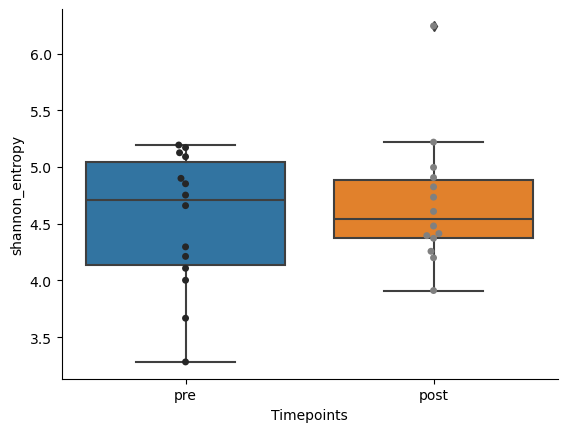

In [150]:
# Alpha div paired
df_alpha = pd.read_csv(path + 'outputs/Qiime2_saliva/metadata.tsv', sep='\t', index_col=0)
df_alpha = df_alpha.drop('#q2:types')
df_alpha['SubjectID'] = df_alpha['Patient_ID'] + df_alpha['Study_ID']
df_alpha = df_alpha[['SubjectID', 'Timepoints', 'shannon_entropy']]

# drop unpaired samples
s_remove = []
for s in list(df_alpha['SubjectID'].values):
    if len(df_alpha[df_alpha['SubjectID'] == s]) != 2:
        s_remove.append(s)
df_alpha = df_alpha.loc[~df_alpha['SubjectID'].isin(s_remove),:] # careful not to use ([s_remove])

# set vars
alpha_metric = 'shannon_entropy'
group_var = 'Timepoints'
pair_var = 'SubjectID'
groups = ['pre','post']

# get paired per indiv pair
pair_to_diff = {}
for p in list(df_alpha[pair_var].values):
    df = df_alpha[df_alpha[pair_var] == p]
    alpha_0 = float(df[df[group_var] == groups[0]][alpha_metric].values)
    alpha_1 = float(df[df[group_var] == groups[1]][alpha_metric].values)
    pair_to_diff[p] = alpha_0 - alpha_1

df_paired_alpha = pd.DataFrame.from_dict(pair_to_diff, orient='index', columns=[alpha_metric + '_diff'])

# one-sided t-test, n.s.; RA-UA values 
t, p = scipy.stats.ttest_1samp(df_paired_alpha[alpha_metric + '_diff'],popmean=0)
print(t, p)

s, p = scipy.stats.wilcoxon(df_paired_alpha[alpha_metric + '_diff'])
print(s, p)
# boxplot of differences
#sns.boxplot(data=df_paired_alpha)
#sns.swarmplot(data=df_paired_alpha, palette='dark:grey')
#sns.despine()

# separate
df_alpha[alpha_metric] = df_alpha[alpha_metric].map(lambda x: float(x))
ax = sns.boxplot(data=df_alpha, x=group_var, y=alpha_metric)
sns.swarmplot(data=df_alpha, x=group_var, y=alpha_metric, palette='dark:grey')
sns.despine()

-1.0978928675059436 0.29077542228297903
42.0 0.33026123046875


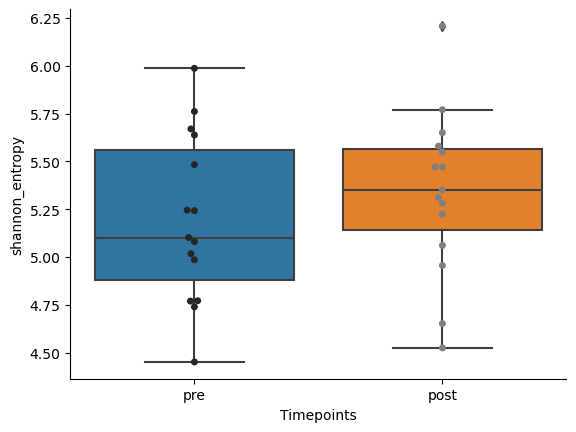

In [156]:
# Alpha div paired
df_alpha = pd.read_csv(path + 'outputs/Qiime2_stool/metadata.tsv', sep='\t', index_col=0)
df_alpha = df_alpha.drop('#q2:types')
df_alpha['SubjectID'] = df_alpha['Patient_ID']
df_alpha = df_alpha[['SubjectID', 'Timepoints', 'shannon_entropy']]

# drop unpaired samples
s_remove = []
for s in list(df_alpha['SubjectID'].values):
    if len(df_alpha[df_alpha['SubjectID'] == s]) != 2:
        s_remove.append(s)
df_alpha = df_alpha.loc[~df_alpha['SubjectID'].isin(s_remove),:] # careful not to use ([s_remove])


# set vars
alpha_metric = 'shannon_entropy'
group_var = 'Timepoints'
pair_var = 'SubjectID'
groups = ['pre','post']

# get paired per indiv pair
pair_to_diff = {}
for p in list(df_alpha[pair_var].values):
    df = df_alpha[df_alpha[pair_var] == p]
    alpha_0 = float(df[df[group_var] == groups[0]][alpha_metric].values)
    alpha_1 = float(df[df[group_var] == groups[1]][alpha_metric].values)
    pair_to_diff[p] = alpha_0 - alpha_1

df_paired_alpha = pd.DataFrame.from_dict(pair_to_diff, orient='index', columns=[alpha_metric + '_diff'])

# one-sided t-test, n.s.; RA-UA values 
t, p = scipy.stats.ttest_1samp(df_paired_alpha[alpha_metric + '_diff'],popmean=0)
print(t, p)

s, p = scipy.stats.wilcoxon(df_paired_alpha[alpha_metric + '_diff'])
print(s, p)
# boxplot of differences
#sns.boxplot(data=df_paired_alpha)
#sns.swarmplot(data=df_paired_alpha, palette='dark:grey')
#sns.despine()

# separate
df_alpha[alpha_metric] = df_alpha[alpha_metric].map(lambda x: float(x))
ax = sns.boxplot(data=df_alpha, x=group_var, y=alpha_metric)
sns.swarmplot(data=df_alpha, x=group_var, y=alpha_metric, palette='dark:grey')
sns.despine()

In [166]:
# check levels of contams
# obtained from 'download csv'
df_otu_meta_stool = pd.read_csv(path + 'outputs/Qiime2_stool/level-6.csv', index_col=0)

# remove metadata
keep_cols = []
for c in list(df_otu_meta_stool.columns.values):
    if 'k__' in c:
        keep_cols.append(c)
df_otu_stool = df_otu_meta_stool[keep_cols]

# normalize
df_otu_stool = df_otu_stool.div(df_otu_stool.sum(axis=1),axis=0)

df_otu_stool.head()

,k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter,k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanosphaera,k__Archaea;p__Euryarchaeota;c__Thermoplasmata;o__E2;f__[Methanomassiliicoccaceae];g__Methanomassiliicoccus,k__Bacteria;__;__;__;__;__,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinobaculum,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Mobiluncus,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Varibaculum,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Corynebacteriaceae;g__Corynebacterium,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Micrococcaceae;g__Nesterenkonia,...,k__Bacteria;p__Synergistetes;c__Synergistia;o__Synergistales;f__Dethiosulfovibrionaceae;g__Jonquetella,k__Bacteria;p__Synergistetes;c__Synergistia;o__Synergistales;f__Synergistaceae;g__Cloacibacillus,k__Bacteria;p__Synergistetes;c__Synergistia;o__Synergistales;f__Synergistaceae;g__Synergistes,k__Bacteria;p__Tenericutes;__;__;__;__,k__Bacteria;p__Tenericutes;c__Mollicutes;o__RF39;f__;g__,k__Bacteria;p__Tenericutes;c__RF3;o__ML615J-28;f__;g__,k__Bacteria;p__Verrucomicrobia;c__Opitutae;__;__;__,k__Bacteria;p__Verrucomicrobia;c__Opitutae;o__[Cerasicoccales];f__[Cerasicoccaceae];g__,k__Bacteria;p__Verrucomicrobia;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Verrucomicrobiaceae;__,k__Bacteria;p__Verrucomicrobia;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Verrucomicrobiaceae;g__Akkermansia
index,,,,,,,,,,,,,,,,,,,,,
OAD-001.post.stool.guma.plate313,0.006187,0.001754,0.0,0.000048,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.002488,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
OAD-001.pre.stool.guma.plate313,0.012105,0.000783,0.0,0.000119,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000546,0.0,0.000000,0.0,0.0,0.0,0.0,0.002373
OAD-003.post.stool.guma.plate313,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
OAD-003.pre.stool.guma.plate313,0.000000,0.000000,0.0,0.000000,0.0,0.000272,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
OAD-004.post.stool.guma.plate313,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.023107,0.0,0.0,0.0,0.0,0.000000


In [168]:
# test cols for taxa of interest
test_cols = []
for c in list(df_otu_stool.columns.values):
    if 'g__[Eubacterium]' in c  or 'g__Lactococcus' in c: # flexi, 'f__Phyllobacteriaceae;g__' in c
        test_cols.append(c)
df_otu_stool = df_otu_stool[test_cols]
#df_otu_test.mean(axis=1)
# very low abundance overall, 3 samples inpost and 1 sample in pre with 0.00002 as max rel abundance 
print(test_cols)
# individual box/barplots
df_lefse = pd.concat([df_otu_stool, df_otu_meta_stool['Timepoints']], axis=1)

for t in test_cols:
    print(t)
    ax = sns.boxplot(data=df_lefse, x='Timepoints', y=t)
    sns.swarmplot(data=df_lefse, x='Timepoints', y=t, palette='dark:grey', hue=None)
    
    # ax.axes.set_title("Title",fontsize=48)
    ax.set_ylabel("Abundance " + t.split('__')[-1],fontsize=16)
    ax.set_xlabel("Timepoint",fontsize=16)
    ax.tick_params(labelsize=16)
    sns.despine()
    plt.tight_layout()
    plt.savefig(path + 'outputs/jobs01/' + t.split('__')[-1] + '.pdf')
    plt.close()

print('Done')

['k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Lactococcus', 'k__Bacteria;p__Firmicutes;c__Erysipelotrichi;o__Erysipelotrichales;f__Erysipelotrichaceae;g__[Eubacterium]']
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Lactococcus
k__Bacteria;p__Firmicutes;c__Erysipelotrichi;o__Erysipelotrichales;f__Erysipelotrichaceae;g__[Eubacterium]
Done


7.62468122175069 0.000591850087575289


<Axes: xlabel='category', ylabel='distance'>

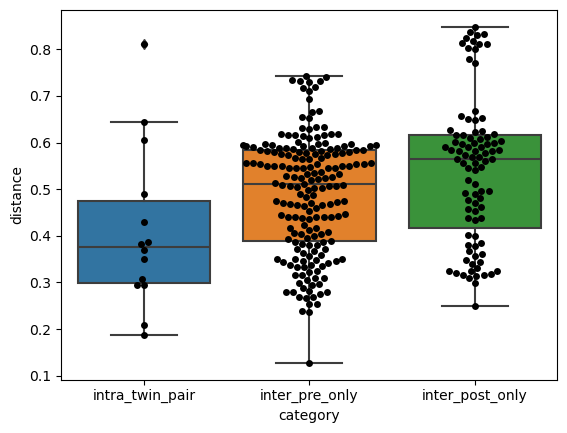

In [97]:
# paired beta, comparing intra-indiv difference pre_post to inter pre and inter post
df_beta = pd.read_csv(path + 'outputs/Qiime2_saliva/core_metrics_results/distance-matrix.tsv',
                      sep='\t', index_col=0)

# set vars
alpha_metric = 'shannon_entropy'
group_var = 'Timepoints'
pair_var = 'SubjectID'
groups = ['pre','post']
g0, g1 = groups[0], groups[1]

# grab twin to pair dict
pair_to_ids = {}
for p in list(df_alpha[pair_var].values):
    df = df_alpha[df_alpha[pair_var] == p]
    id_0 = str(df[df[group_var] == g0].index.values[0])
    id_1 = str(df[df[group_var] == g1].index.values[0])
    pair_to_ids[p] = (id_0, id_1)

# get distances for each twin pair per beta div matrix    
pair_to_dist = {}
for p in list(df_alpha[pair_var].values):
    id_0, id_1 = pair_to_ids[p]
    pair_to_dist[p] = df_beta.loc[id_0, id_1]

df_paired_beta = pd.DataFrame.from_dict(pair_to_dist, orient='index', columns=['Unweighted_Unifrac'])

# grab inter RA distances
# this is from bray_curtis_significance_Diagnosis.qzv -> download as tsv
df_raw = pd.read_csv(path + 'outputs/Qiime2_0/raw_data.tsv', 
                     sep='\t', index_col=0)
df_0 = df_raw[df_raw['Group1'] == g0]
df_0 = df_0[df_0['Group2'] == g0]
df_1 = df_raw[df_raw['Group1'] == g1]
df_1 = df_1[df_1['Group2'] == g1]

# compare distances
inter_twin = df_paired_beta['Unweighted_Unifrac'].values
inter_0 = df_0['Distance'].values
inter_1 = df_1['Distance'].values

u, p = scipy.stats.mannwhitneyu(inter_twin, inter_0)
#print(u, p)

t, p = scipy.stats.ttest_ind(inter_twin, inter_1)
#print(t, p)

t, p = scipy.stats.ttest_ind(inter_0, inter_1)
# print(t, p)

f, p = scipy.stats.f_oneway(inter_0, inter_1, inter_twin)
print(f, p)

category = ['intra_twin_pair']*len(inter_twin) + ['inter_' + g0 + '_only']*len(inter_0) + ['inter_' + g1 + '_only']*len(inter_1)
distances = list(inter_twin) + list(inter_0) + list(inter_1)
df_dist = pd.DataFrame(data=np.array([category,distances]).T, columns=['category','distance'])
df_dist['distance'] = df_dist['distance'].astype(float)
df_dist.to_csv(path + 'outputs/Qiime2_0/inter_intra_beta_dist.tsv',sep='\t')
                     
sns.boxplot(data=df_dist, x='category', y='distance')
sns.swarmplot(data=df_dist, x='category', y='distance', color='black')


In [253]:
# saliva stool correlations
df_saliva_meta = pd.read_csv(path + 'inputs/saliva_normalized.csv')
df_saliva_meta['#SampleID'] = df_saliva_meta['Study_ID'] + df_saliva_meta['Label'] + '.saliva'
df_saliva_meta['#SampleID'] = df_saliva_meta['#SampleID'].str.replace('_1mAfter diet', '.post')
df_saliva_meta['#SampleID'] = df_saliva_meta['#SampleID'].str.replace('_0Baseline', '.pre')    
df_saliva_meta['#SampleID'] = df_saliva_meta['#SampleID'].str.replace('D0', 'D-0')    
df_saliva_meta = df_saliva_meta.drop(['Study_ID','Label'], axis=1)
df_saliva_meta = df_saliva_meta.set_index('#SampleID')
# df_map_saliva has these VAOAD-001.pre.saliva as sample id index
#df_saliva = pd.concat([df_saliva_map

# saliva stool correlations
df_stool_meta = pd.read_csv(path + 'inputs/stool_normalized.csv')
df_stool_meta['#SampleID'] = df_stool_meta['Study_ID'] + df_stool_meta['Time'] + '.stool'
df_stool_meta['#SampleID'] = df_stool_meta['#SampleID'].str.replace('_1mAfter diet', '.post')
df_stool_meta['#SampleID'] = df_stool_meta['#SampleID'].str.replace('_0Baseline', '.pre')    
df_stool_meta['#SampleID'] = df_stool_meta['#SampleID'].str.replace('D0', 'D-0')    
df_stool_meta = df_stool_meta.drop(['Study_ID','Time'], axis=1)
df_stool_meta = df_stool_meta.set_index('#SampleID')
df_stool_meta.head()#['#SampleID']

,H_Pyridoxamine,H_Thiamine,H_Melezitose,H_Phosphocholine,H_SN_Glycero_3_Phophocholine,H_Gamma_Valerobetaine,H_N_Acetylneuraminic_acid,H_Pyridoxine,H_N_Acetylneuraminic_Acid,H_N_Acetylmuramic_Acid,...,H_Nonhydroxylated_bile_acid,H_Hydroxydodecanoic_acid,H_Omega_Hydroxydodecanoate,H_Delta_Methyldodecenoic_Acid,H_Hydroxydecanoic_acid,H_Hydroxydecanoate,H_Methylpentanoic_acid,H_Monohydroxylated_bile_acid,H_Palmitoyl_ethanolamide,H_Linoleic_Acid
#SampleID,,,,,,,,,,,,,,,,,,,,,
VAOAD-001.post.stool,0.312342,-0.312477,0.119853,-0.492876,-0.671376,-0.202952,0.203945,-0.455869,0.352628,0.151464,...,0.054336,-0.330037,-0.886045,-0.314427,-0.322677,-0.650357,-0.361695,0.132794,-0.067464,-0.112641
VAOAD-009.post.stool,0.000428,-0.481251,-0.179337,0.983217,0.167836,0.067823,0.364897,-0.371942,0.545435,-0.007664,...,-0.022614,-0.334936,-0.802118,-0.929470,-0.369578,-0.566431,0.075375,-0.519189,-0.180631,-0.418351
OAD-001.post.stool,-0.285212,-0.556445,-0.651325,0.357509,-0.401875,-0.295787,0.137736,-0.165902,0.112170,0.096791,...,-0.923477,-0.589028,-1.535141,-0.525277,-0.278312,-0.600484,0.019657,-0.576831,-0.901479,-1.089906
VAOAD-004.post.stool,0.140904,1.089055,-0.668077,-1.061336,-0.370602,-0.329379,-0.654931,0.142971,-1.006689,-0.100373,...,-0.354297,0.449897,0.489189,0.413723,0.474250,0.661963,0.245553,0.279290,-0.444319,-0.912164
VAOAD-011.post.stool,-0.346855,1.028262,-0.450323,-0.025939,-0.223029,-0.766374,-0.538410,-1.091423,-0.328522,-0.524686,...,-0.385428,0.419748,0.429119,0.333756,0.448461,0.598846,0.390035,0.287682,-0.532141,-0.752280


['WOMAC_P_resp_MCID', 'WOMAC_s_response', 'WOMAC_S_resp_MCID', 'WOMAC_act_Response', 'WOMAC_A_resp_MCID', 'WOMAC_response', 'WOMAC_T_resp_MCID']
['WOMAC_P_percentaje', 'WOMAC_stiffness', 'WOMAC_stiff_percentaje', 'WOMAC_activity', 'WOMAC_act_percentja', 'WOMAC_total']


,var,effect,pval,stat
0,WOMAC_P_resp_MCID,0.000000,1.000000,chi2
0,WOMAC_s_response,0.000000,1.000000,chi2
0,WOMAC_S_resp_MCID,1.636829,0.200761,chi2
0,WOMAC_act_Response,0.000000,1.000000,chi2
0,WOMAC_A_resp_MCID,0.000000,1.000000,chi2


In [ ]:
# CUTIE, binarize womac var and then do correlations with 
# Hypothesis 2: There will be an association between oral and gut microbiome and pain outcomes
# can do paired diff in resp vars and paired diff (or ratio) of taxa
# should throw in diversity as well (alpha, and beta pcs for unpaired) and alpha diff, beta diff for paired

# start with unpaired unstratified and binarize
df_meta_cutie = df_meta[womac]

# grab df_alpha
df_alpha_stool = pd.read_csv(path + 'outputs/Qiime2_stool/metadata.tsv', sep='\t', index_col=0)
df_alpha_stool = df_alpha_stool.drop('#q2:types')
df_alpha_stool['SubjectID'] = df_alpha_stool['Patient_ID']
df_alpha_stool = df_alpha_stool[['SubjectID', 'Timepoints', 'shannon_entropy']]

df_alpha_saliva = pd.read_csv(path + 'outputs/Qiime2_saliva/metadata.tsv', sep='\t', index_col=0)
df_alpha_saliva = df_alpha_saliva.drop('#q2:types')
df_alpha_saliva['SubjectID'] = df_alpha_saliva['Patient_ID']
df_alpha_saliva = df_alpha_saliva[['SubjectID', 'Timepoints', 'shannon_entropy']]

# grab beta ordination
df_beta_stool = pd.read_csv(path + 'outputs/Qiime2_stool/core_metrics_results/ordination.txt', sep='\t', skiprows=9)#, index_col=0)
df_beta_stool = df_beta_stool.iloc[:,:6]
df_beta_stool = df_beta_stool.T.reset_index(drop=True).T
df_beta_stool.columns = ['SampleID'] + ['PC' + str(x+1) for x in range(5)]
df_beta_stool = df_beta_stool.set_index('SampleID')

df_beta_saliva = pd.read_csv(path + 'outputs/Qiime2_saliva/core_metrics_results/ordination.txt', sep='\t', skiprows=9)#, index_col=0)
df_beta_saliva = df_beta_saliva.iloc[:,:6]
df_beta_saliva = df_beta_saliva.T.reset_index(drop=True).T
df_beta_saliva.columns = ['SampleID'] + ['PC' + str(x+1) for x in range(5)]
df_beta_saliva = df_beta_saliva.set_index('SampleID')


df_alpha_saliva.head()
# merge saliva and stool otu tables; make index OAD-001
# add _stool and _saliva suffix to OTU tables
#print(len(df_meta_cutie))
#df_meta_cutie.head()
# df_meta_cutie.index.values

In [137]:
# figure out what columns to keep and what to binarize
keep_cols = ['BarcodeSequence', 'LinkerPrimerSequence', 'Patient_ID',
       'Timepoints', 'Study_ID', 'Run_ID_Stool', 'Run_ID_Saliva', 'Visit',
       'Sex', 'Age', 'Height', 'Weight', 'BMI', 'Bajo_BMI', 'Ethnicity',
       'Race', 'Highest_level_of_education', 'Working_status',
       'Marital_status', 'DM', 'HTN', 'Dyslipidemia', 'Knee_injury',
       'Years_OA_diagnosis', 'NSAIDs', 'Tylenol', 'Narcotics', 'CBD',
       'Meformin', 'other_DM', 'Knee_pain_last_week',
       'Knee_pain_response', 'Knee_pain_improvement', 'Days_limitation',
       'Stiffness_min', 'VAS_Pt', 'VAS_response', 'VAS_resp_MCID',
       'VAS_resp_%', 'VAS_fatigue', 'VAS_fat_response',
       'VAS_fati_percentage', 'VAS_stress', 'VAS_stress_response',
       'VAS_stress_percentage', 'VAS_overall', 'VAS_overall_response',
       'VAS_overall_resp_MCID', 'VAS_overall_percentage', 'Swollen_knee',
       'Grinding_knee', 'Catching_knee', 'Straighten_knee', 'Bend_knee',
       'affected_joint', 'WOMAC_pain', 'WOMAC_P_Response',
       'WOMAC_P_resp_MCID', 'WOMAC_P_percentaje', 'WOMAC_stiffness',
       'WOMAC_s_response', 'WOMAC_S_resp_MCID', 'WOMAC_stiff_percentaje',
       'WOMAC_activity', 'WOMAC_act_Response', 'WOMAC_A_resp_MCID',
       'WOMAC_act_percentja', 'WOMAC_total', 'WOMAC_response',
       'WOMAC_T_resp_MCID', 'Unnamed: 68', 'Pain_DETECT',
       'P_detect_respone', 'Neuropatic_pain', 'CES_D', 'CES_D_response',
       'CES_D_percentaje', 'Helplesness', 'Helplessness_response',
       'Helplessness_percentaje', 'Magnification',
       'Magnification_response', 'Magnification_percetange', 'Rumination',
       'Rumination_response', 'Rumination_percentahe', 'PCS_EN',
       'PCS_EN_response', 'PCS_EN_percentaje', 'Sleep_distrubance',
       'sleep_Response', 'sleep_percentage', 'PASE_walk', 'PASE_light',
       'light_improvement', 'PASE_moderate', 'moderate_improvement',
       'PASE-strenuous', 'PASE-muscle', 'PASE_lighthouse',
       'PASE_heavyhouse', 'PASE_9abcd', 'gardening_improve',
       'PASE_work/volunteer', 'PASE_total', 'PPT_Rwrist', 'PPT_Rpatella',
       'PPT_Rtuberosity', 'PPT_Rmedial', 'PPT_Lpatella',
       'PPT_Ltuberosity', 'PPT_Lmedial', 'Synovitis_GS', 'Synovitis_PD',
       'Effusion', 'animal_proteins_red', 'refined_grains', 'solanaceae',
       'saturated', 'pastries', 'milk_derivates', 'beverages_prohibited',
       'pro_inflammatory', 'chicken', 'plant_protein',
       'whole_grains_pseudocereals_oats', 'gluten_free', 'vegetables',
       'cruciferous', 'berries_and_enzymatic_fruit', 'other_fruit',
       'fish', 'milk_subs', 'PUFA', 'MUFA', 'Walnuts', 'Nuts',
       'probiotics', 'Tahini_avo', 'green_tea', 'anti_inflam_spices',
       'inflammatory_spices', 'inflammatory', 'anti_inflammatory',
       'total_antiinflammatory', 'Adherece_antiinflam', 'oats',
       'almond_milk', 'fatty_fish', 'sesame_seeds', 'egg', 'chia',
       'flaxseed_oil', 'walnuts', 'spinach', 'corn_tortilla', 'tahini',
       'avocado', 'chicken.1', 'brown_rice', 'corn', 'quinoa', 'broccoli',
       'Garbanzo_beans', 'pork', 'beef', 'burger', 'Total_omega3',
       'Adherence_omega3', 'Total_omega6', 'Adherence_omega6',
       'Total_o3_o6']

bin_cols = 'Timepoints'
drop_cols = ['BarcodeSequence', 'LinkerPrimerSequence', 'Patient_ID',
       'Timepoints', 'Study_ID', 'Run_ID_Stool', 'Run_ID_Saliva', 'Visit',
       'Sex', 'Age', 'Height', 'Weight', 'BMI', 'Bajo_BMI', 'Ethnicity',
       'Race', 'Highest_level_of_education', 'Working_status',
       'Marital_status', 'DM', 'HTN', 'Dyslipidemia', 'Knee_injury',
       'Years_OA_diagnosis', 'NSAIDs', 'Tylenol', 'Narcotics', 'CBD',
       'Meformin', 'other_DM', 'Knee_pain_last_week',
       'Knee_pain_response', 'Knee_pain_improvement', 'Days_limitation',
       'Stiffness_min', 'VAS_Pt', 'VAS_response', 'VAS_resp_MCID',
       'VAS_resp_%', 'VAS_fatigue', 'VAS_fat_response',
       'VAS_fati_percentage', 'VAS_stress', 'VAS_stress_response',
       'VAS_stress_percentage', 'VAS_overall', 'VAS_overall_response',
       'VAS_overall_resp_MCID', 'VAS_overall_percentage', 'Swollen_knee',
       'Grinding_knee', 'Catching_knee', 'Straighten_knee', 'Bend_knee',
       'affected_joint', 'WOMAC_pain', 'WOMAC_P_Response',
       'WOMAC_P_resp_MCID', 'WOMAC_P_percentaje', 'WOMAC_stiffness',
       'WOMAC_s_response', 'WOMAC_S_resp_MCID', 'WOMAC_stiff_percentaje',
       'WOMAC_activity', 'WOMAC_act_Response', 'WOMAC_A_resp_MCID',
       'WOMAC_act_percentja', 'WOMAC_total', 'WOMAC_response',
       'WOMAC_T_resp_MCID', 'Unnamed: 68', 'Pain_DETECT',
       'P_detect_respone', 'Neuropatic_pain', 'CES_D', 'CES_D_response',
       'CES_D_percentaje', 'Helplesness', 'Helplessness_response',
       'Helplessness_percentaje', 'Magnification',
       'Magnification_response', 'Magnification_percetange', 'Rumination',
       'Rumination_response', 'Rumination_percentahe', 'PCS_EN',
       'PCS_EN_response', 'PCS_EN_percentaje', 'Sleep_distrubance',
       'sleep_Response', 'sleep_percentage', 'PASE_walk', 'PASE_light',
       'light_improvement', 'PASE_moderate', 'moderate_improvement',
       'PASE-strenuous', 'PASE-muscle', 'PASE_lighthouse',
       'PASE_heavyhouse', 'PASE_9abcd', 'gardening_improve',
       'PASE_work/volunteer', 'PASE_total', 'PPT_Rwrist', 'PPT_Rpatella',
       'PPT_Rtuberosity', 'PPT_Rmedial', 'PPT_Lpatella',
       'PPT_Ltuberosity', 'PPT_Lmedial', 'Synovitis_GS', 'Synovitis_PD',
       'Effusion', 'animal_proteins_red', 'refined_grains', 'solanaceae',
       'saturated', 'pastries', 'milk_derivates', 'beverages_prohibited',
       'pro_inflammatory', 'chicken', 'plant_protein',
       'whole_grains_pseudocereals_oats', 'gluten_free', 'vegetables',
       'cruciferous', 'berries_and_enzymatic_fruit', 'other_fruit',
       'fish', 'milk_subs', 'PUFA', 'MUFA', 'Walnuts', 'Nuts',
       'probiotics', 'Tahini_avo', 'green_tea', 'anti_inflam_spices',
       'inflammatory_spices', 'inflammatory', 'anti_inflammatory',
       'total_antiinflammatory', 'Adherece_antiinflam', 'oats',
       'almond_milk', 'fatty_fish', 'sesame_seeds', 'egg', 'chia',
       'flaxseed_oil', 'walnuts', 'spinach', 'corn_tortilla', 'tahini',
       'avocado', 'chicken.1', 'brown_rice', 'corn', 'quinoa', 'broccoli',
       'Garbanzo_beans', 'pork', 'beef', 'burger', 'Total_omega3',
       'Adherence_omega3', 'Total_omega6', 'Adherence_omega6',
       'Total_o3_o6']
df_map_saliva.columns.values

array(['BarcodeSequence', 'LinkerPrimerSequence', 'Patient_ID',
       'Timepoints', 'Study_ID', 'Run_ID_Stool', 'Run_ID_Saliva', 'Visit',
       'Sex', 'Age', 'Height', 'Weight', 'BMI', 'Bajo_BMI', 'Ethnicity',
       'Race', 'Highest_level_of_education', 'Working_status',
       'Marital_status', 'DM', 'HTN', 'Dyslipidemia', 'Knee_injury',
       'Years_OA_diagnosis', 'NSAIDs', 'Tylenol', 'Narcotics', 'CBD',
       'Meformin', 'other_DM', 'Knee_pain_last_week',
       'Knee_pain_response', 'Knee_pain_improvement', 'Days_limitation',
       'Stiffness_min', 'VAS_Pt', 'VAS_response', 'VAS_resp_MCID',
       'VAS_resp_%', 'VAS_fatigue', 'VAS_fat_response',
       'VAS_fati_percentage', 'VAS_stress', 'VAS_stress_response',
       'VAS_stress_percentage', 'VAS_overall', 'VAS_overall_response',
       'VAS_overall_resp_MCID', 'VAS_overall_percentage', 'Swollen_knee',
       'Grinding_knee', 'Catching_knee', 'Straighten_knee', 'Bend_knee',
       'affected_joint', 'WOMAC_pain', 'WOMAC_P_Res

In [236]:
# correlate bacteria with pain scores

df_combined = pd.concat([df_otu_saliva, df_map_saliva], axis=1)



for o in list(df_otu_saliva.columns.values):#[:100]:
    otu = df_combined[o].values
    for w in womac:
        df_w = df_combined[w]
        w_var = df_w.values
        if df_w.nunique() > 2: # do spearman
            T,p = scipy.stats.spearmanr(a=otu,b=w_var,nan_policy='omit')
            if p < 0.05:
                print(o,w)
                print(T,p)            
                sns.lmplot(data=df_combined, x=o, y=w)
            
                # ax.axes.set_title("Title",fontsize=48)
                ax.set_ylabel(w ,fontsize=16)
                ax.set_xlabel("OTU " + o.split('__')[-1],fontsize=16)
                ax.tick_params(labelsize=16)
                sns.despine()
                plt.tight_layout()
                plt.savefig(path + 'outputs/jobs01/corr_' + w + '__' + o.split('__')[-1] + '.pdf')
                plt.close()            
'''
        else:  #else do rank sum
            w_var = df_w.values
            poss = df_w.unique()
            df = pd.DataFrame.from_dict(data={'group':w_var, 'var':otu})       
            g1 = df[df['group'] == poss[0]]['var'].values
            g2 = df[df['group'] == poss[1]]['var'].values
            T,p = scipy.stats.mannwhitneyu(x=g1,y=g2)
            if p < 0.05:
                print(o,w)
                print(T,p)
            
                ax = sns.boxplot(data=df_combined, x=o, y=w, orient='h')
                sns.swarmplot(data=df_combined, x=o, y=w, palette='dark:grey', hue=None, orient='h')
            
                # ax.axes.set_title("Title",fontsize=48)
                ax.set_ylabel(w,fontsize=16)
                ax.set_xlabel("OTU " + o.split('__')[-1],fontsize=16)                
                ax.tick_params(labelsize=16)
                sns.despine()
                plt.tight_layout()
                plt.savefig(path + 'outputs/jobs01/mwu_' + w + '__' + o.split('__')[-1] + '.pdf')
                plt.close()            
'''


k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Pseudonocardiaceae;g__Pseudonocardia WOMAC_P_percentaje
0.552947535583405 0.049997558383318055
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Pseudonocardiaceae;g__Pseudonocardia WOMAC_stiffness
-0.4048967779067612 0.02151901628182447
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Pseudonocardiaceae;g__Pseudonocardia WOMAC_activity
-0.4319797088826837 0.013551991052384138
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Pseudonocardiaceae;g__Pseudonocardia WOMAC_total
-0.4526757744770242 0.00928220433822542
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Alloscardovia WOMAC_stiffness
0.4076282244243862 0.02057158890965467
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;__;__ WOMAC_P_percentaje
-0.570966799752624 0.041544291264081344
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;

'\n        else:  #else do rank sum\n            w_var = df_w.values\n            poss = df_w.unique()\n            df = pd.DataFrame.from_dict(data={\'group\':w_var, \'var\':otu})       \n            g1 = df[df[\'group\'] == poss[0]][\'var\'].values\n            g2 = df[df[\'group\'] == poss[1]][\'var\'].values\n            T,p = scipy.stats.mannwhitneyu(x=g1,y=g2)\n            if p < 0.05:\n                print(o,w)\n                print(T,p)\n            \n                ax = sns.boxplot(data=df_combined, x=o, y=w, orient=\'h\')\n                sns.swarmplot(data=df_combined, x=o, y=w, palette=\'dark:grey\', hue=None, orient=\'h\')\n            \n                # ax.axes.set_title("Title",fontsize=48)\n                ax.set_ylabel(w,fontsize=16)\n                ax.set_xlabel("OTU " + o.split(\'__\')[-1],fontsize=16)                \n                ax.tick_params(labelsize=16)\n                sns.despine()\n                plt.tight_layout()\n                plt.savefig(path